# Stage 2: Model training

In this tutorial, we will show how to train a GLUE model to integrate unpaired single-cell multi-omics data. We continue with the previous example of scRNA-seq and scATAC-seq data integration.

In [1]:
from itertools import chain

import anndata as ad
import itertools
import networkx as nx
import pandas as pd
import scanpy as sc
import scglue
import seaborn as sns
from matplotlib import rcParams

In [2]:
scglue.plot.set_publication_params()
rcParams["figure.figsize"] = (4, 4)

## Read preprocessed data

First, read the preprocessed data as produced by [stage 1](preprocessing.ipynb).

In [3]:
rna = ad.read_h5ad("rna-pp.h5ad")
atac = ad.read_h5ad("atac-pp.h5ad")
guidance = nx.read_graphml("guidance.graphml.gz")

## Configure data

> (Estimated time: negligible)

Before model training, we need to configure the datasets using [scglue.models.configure_dataset](api/scglue.models.configure_dataset.rst). For each dataset to be integrated, we need to specify a probabilistic generative model. Here we model the raw counts of both scRNA-seq and scATAC-seq using the negative binomial distribution (`"NB"`).

Optionally, we can specify whether only the highly variable features should be used (`use_highly_variable`), what data layer to use (`use_layer`), as well as what preprocessing embedding (`use_rep`) to use as first encoder transformation.

* For the scRNA-seq data, we use the [previously backed up](preprocessing.ipynb#Preprocess-scRNA-seq-data) raw counts in the "counts" layer, and use the PCA embedding as the first encoder transformation.
* For the scATAC-seq data, the raw counts are just `atac.X`, so it's unnecessary to specify `use_layer`. We use the LSI embedding as the first encoder transformation.

In [4]:
scglue.models.configure_dataset(
    rna, "NB", use_highly_variable=True,
    use_layer="counts", use_rep="X_pca"
)

In [5]:
scglue.models.configure_dataset(
    atac, "NB", use_highly_variable=True,
    use_rep="X_lsi"
)

Other useful options of [scglue.models.configure_dataset](api/scglue.models.configure_dataset.rst) include:

* `use_batch`: Setting this to an `obs` column tells the model to treat it as a batch effect to be corrected for;
* `use_cell_type`: Setting this to an `obs` column tells the model to use it as cell type supervision.

Next, as we are only using highly-variable features, we also extract a subgraph containing only these highly variable features from the full guidance graph:

In [6]:
guidance_hvf = guidance.subgraph(chain(
    rna.var.query("highly_variable").index,
    atac.var.query("highly_variable").index
)).copy()

## Train GLUE model

> (Estimated time: 15-60 min, depending on computation device)

Next we train a [GLUE model](api/scglue.models.scglue.SCGLUEModel.rst) for integrating the two omics layers.

* The datasets to be integrated are specified as a `dict`, where the keys are domain names. The domain names can be set at your discretion, as long as they are kept consistent (see below).
* Here we specified a directory to the fit function where model snapshots and training logs will be stored.
* For more advanced usages, please refer to the [function documentation](api/scglue.models.fit_SCGLUE.rst).

In [7]:
glue = scglue.models.fit_SCGLUE(
    {"rna": rna, "atac": atac}, guidance_hvf,
    fit_kws={"directory": "glue"}
)

[INFO] fit_SCGLUE: Pretraining SCGLUE model...
[INFO] autodevice: Using GPU 0 as computation device.
[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] SCGLUEModel: Setting `graph_batch_size` = 27025
[INFO] SCGLUEModel: Setting `max_epochs` = 186
[INFO] SCGLUEModel: Setting `patience` = 16
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 8
[INFO] SCGLUETrainer: Using training directory: "glue/pretrain"
[INFO] SCGLUETrainer: [Epoch 10] train={'g_nll': 0.451, 'g_kl': 0.004, 'g_elbo': 0.456, 'x_rna_nll': 0.165, 'x_rna_kl': 0.006, 'x_rna_elbo': 0.171, 'x_atac_nll': 0.04, 'x_atac_kl': 0.0, 'x_atac_elbo': 0.041, 'dsc_loss': 0.692, 'vae_loss': 0.23, 'gen_loss': 0.196}, val={'g_nll': 0.45, 'g_kl': 0.004, 'g_elbo': 0.454, 'x_rna_nll': 0.166, 'x_rna_kl': 0.006, 'x_rna_elbo': 0.172, 'x_atac_nll': 0.04, 'x_atac_kl': 0.0, 'x_atac_elbo': 0.04, 'dsc_loss': 

2022-08-10 11:15:59,205 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "52"...
[INFO] fit_SCGLUE: Estimating balancing weight...
[INFO] estimate_balancing_weight: Clustering cells...
[INFO] estimate_balancing_weight: Matching clusters...
[INFO] estimate_balancing_weight: Matching array shape = (16, 18)...
[INFO] estimate_balancing_weight: Estimating balancing weight...
[INFO] fit_SCGLUE: Fine-tuning SCGLUE model...
[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] SCGLUEModel: Setting `graph_batch_size` = 27025
[INFO] SCGLUEModel: Setting `align_burnin` = 31
[INFO] SCGLUEModel: Setting `max_epochs` = 186
[INFO] SCGLUEModel: Setting `patience` = 16
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 8
[INFO] SCGLUETrainer: Using training directory: "glue/fine-tune"
[INFO] SCGLUETrainer: [Epoch 10] train={'g_nll': 0.418, 'g_kl': 0.004, 'g_elbo': 0.421, 'x_rna_nll': 0.161, '

2022-08-10 11:28:49,337 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "84"...


If you have tensorboard installed, you can monitor the training progress by running `tensorboard --logdir=glue` at the command line.

After convergence, the trained model can be saved and loaded as ".dill" files.

In [8]:
glue.save("glue.dill")
# glue = scglue.models.load_model("glue.dill")

## Check integration diagnostics

> (Estimated time: ~2 min)

To check whether the integration is reliable, we provide an "integration consistency score", which quantifies the consistency between the integration result and the guidance graph.
The score can be computed using the [scglue.models.integration_consistency](api/scglue.models.dx.integration_consistency.rst) function.

* We need to provide the function with the trained model, data, as well as the guidance graph.
* We also need to explicitly specify layers containing raw counts if it is not `.X`.

In [9]:
dx = scglue.models.integration_consistency(
    glue, {"rna": rna, "atac": atac}, guidance_hvf
)
dx

[INFO] integration_consistency: Using layer "counts" for modality "rna"
[INFO] integration_consistency: Selecting aggregation "sum" for modality "rna"
[INFO] integration_consistency: Selecting aggregation "sum" for modality "atac"
[INFO] integration_consistency: Selecting log-norm preprocessing for modality "rna"
[INFO] integration_consistency: Selecting log-norm preprocessing for modality "atac"
[INFO] get_metacells: Clustering metacells...
[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 10 common metacells...
[INFO] get_metacells: Clustering metacells...
[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 20 common metacells...
[INFO] get_metacells: Clustering metacells...
[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 50 common metacells...
[INFO] get_metacells: Clustering metacells...
[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_co

,n_meta,consistency
0,10,0.191005
1,20,0.158123
2,50,0.114271
3,100,0.087477
4,200,0.066906


Notice that the consistency score is computed across different numbers of "metacells", which can be visualized as a curve:

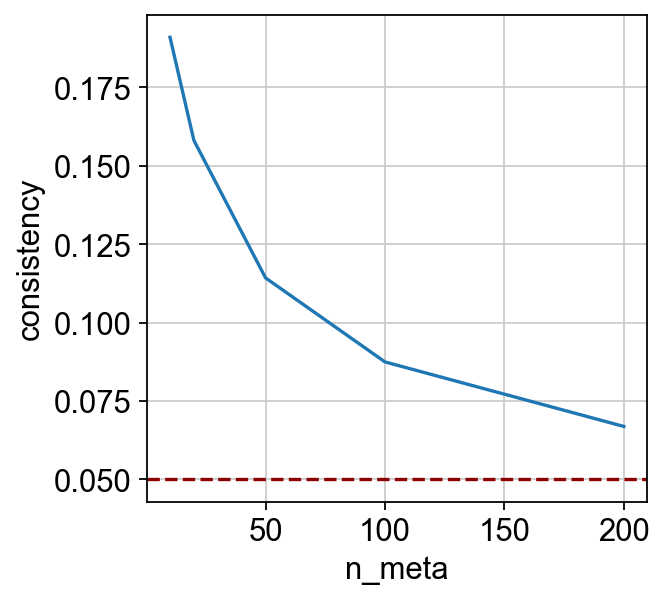

In [10]:
_ = sns.lineplot(x="n_meta", y="consistency", data=dx).axhline(y=0.05, c="darkred", ls="--")

The higher is curve gets, the more confident the integration is.
Empirically, it is safe to assume that the integration is reliable if the curve is above the 0.05 line.

## Apply model for cell and feature embedding

> (Estimated time: ~2 min)

With the trained model, we can use the [encode_data](api/scglue.models.scglue.SCGLUEModel.encode_data.rst) method to project the single-cell omics data to cell embeddings. The first argument to [encode_data](api/scglue.models.scglue.SCGLUEModel.encode_data.rst) specifies the domain to encode (one of the previous domain names), and the second specifies the dataset to be encoded. By convention, we store the cell embeddings in the [obsm](https://anndata.readthedocs.io/en/latest/generated/anndata.AnnData.obsm.html#anndata.AnnData.obsm) slot, with name `"X_glue"`.

In [11]:
rna.obsm["X_glue"] = glue.encode_data("rna", rna)
atac.obsm["X_glue"] = glue.encode_data("atac", atac)

To jointly visualize the cell embeddings from two omics layers, we construct a combined dataset.

In [12]:
combined = ad.concat([rna, atac])

Then we use UMAP to visualize the aligned embeddings. We can see that the two omics layers are now correctly aligned.

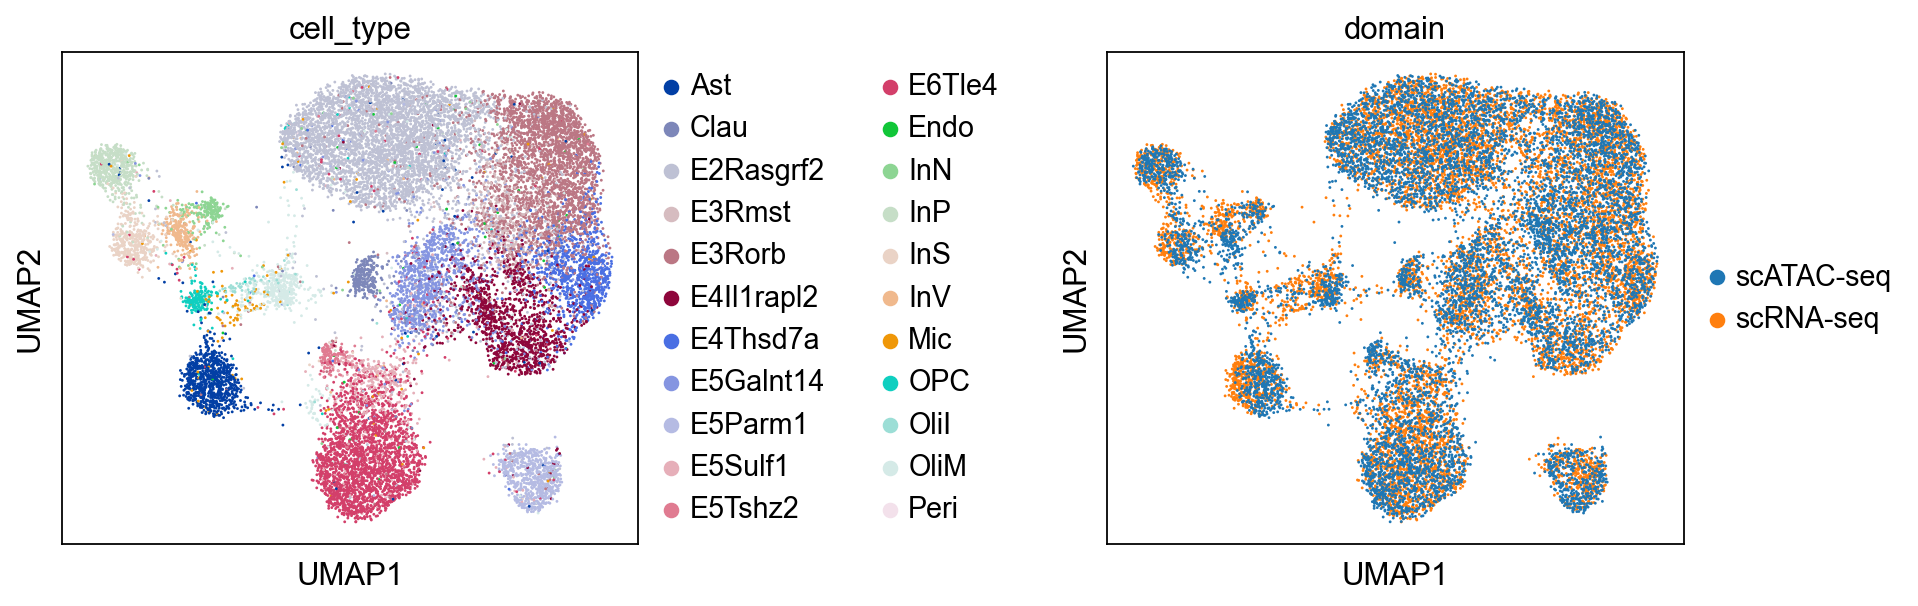

In [13]:
sc.pp.neighbors(combined, use_rep="X_glue", metric="cosine")
sc.tl.umap(combined)
sc.pl.umap(combined, color=["cell_type", "domain"], wspace=0.65)

To obtain feature embeddings, we can use the [encode_graph](api/scglue.models.scglue.SCGLUEModel.encode_graph.rst) method.

In [14]:
feature_embeddings = glue.encode_graph(guidance_hvf)
feature_embeddings = pd.DataFrame(feature_embeddings, index=glue.vertices)
feature_embeddings.iloc[:5, :5]

,0,1,2,3,4
0610009B22Rik,0.003167,1.164528,0.001782,0.002524,-0.001086
0610025J13Rik,0.007353,1.800663,-0.002449,-0.001597,0.002197
1110002J07Rik,0.001606,1.306113,0.002979,-0.003802,-0.002259
1110006O24Rik,0.000742,1.436544,0.002607,-0.005381,-0.004283
1110020A21Rik,-0.003964,1.571156,0.006464,0.001598,-0.000315


We store the feature embeddings into the [varm](https://anndata.readthedocs.io/en/latest/generated/anndata.AnnData.obsm.html#anndata.AnnData.varm) slots of AnnData objects, also with name `"X_glue"`.

In [15]:
rna.varm["X_glue"] = feature_embeddings.reindex(rna.var_names).to_numpy()
atac.varm["X_glue"] = feature_embeddings.reindex(atac.var_names).to_numpy()

We now save the AnnData objects with cell and feature embeddings, as well as the guidance graph containing only highly-variable features.

In [16]:
rna.write("rna-emb.h5ad", compression="gzip")
atac.write("atac-emb.h5ad", compression="gzip")
nx.write_graphml(guidance_hvf, "guidance-hvf.graphml.gz")

For regulatory inference using the GLUE embeddings, please refer to [stage 3](reginf.ipynb).